In [69]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 1


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = None
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json


In [3]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))

2000
57884
134125


In [4]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,None,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,None,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,None,14039958,1505692800,korean,51,31,18,1,64,2
3,false,None,28926058,1501027200,mat,107,86,4,1,126,3
4,false,None,4335282,1401667200,90s,16,16,7,2,17,4


In [5]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time
spotify:track:002PgfoyfrOGiKch4EW8Wm,Alan Menken,spotify:artist:5sy77gt4bfsLcSQ8GIe4ZZ,Jasmine Runs Away,spotify:album:29EiOQJnxWlX5nVOWQpu3u,46866,Aladdin
spotify:track:004skCQeDn1iLntSom0rRr,Kevin Jonas,spotify:artist:11bdWrCwHE2gCdVARdASuu,Heart and Soul,spotify:album:5iK842b9xnZblgZkRxWCFe,177773,Camp Rock 2: The Final Jam
spotify:track:005CGalYNgMNZcvWMIFeK8,Nelson Y Sus Estrellas,spotify:artist:5SRwYMyavJCNT2AdVMpPgi,LLorándote,spotify:album:2TfoLoZHhsL0oAYBxDi4t2,321480,Orquídea de Plata


In [6]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


In [7]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [8]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,None,3675883,1496793600,quiet,15,14,4,1,15
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,None,3675883,1496793600,quiet,15,14,4,1,15
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,None,3675883,1496793600,quiet,15,14,4,1,15
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,None,3675883,1496793600,quiet,15,14,4,1,15
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,None,3675883,1496793600,quiet,15,14,4,1,15


In [9]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


100%|██████████| 2000/2000 [03:14<00:00, 10.29it/s]


In [10]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [ ]:
negative_samples.head()

In [ ]:
merged.head()

In [ ]:
negative_samples.head()

In [14]:
merged.columns

Index(['track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name',
       'playlist_pid', 'track_uri', 'playlist_collaborative',
       'playlist_description', 'playlist_duration_ms', 'playlist_modified_at',
       'playlist_name', 'playlist_num_albums', 'playlist_num_artists',
       'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
       'match'],
      dtype='object')

In [15]:
negative_samples.columns

Index(['playlist_pid', 'playlist_collaborative', 'playlist_description',
       'playlist_duration_ms', 'playlist_modified_at', 'playlist_name',
       'playlist_num_albums', 'playlist_num_artists', 'playlist_num_edits',
       'playlist_num_followers', 'playlist_num_tracks', 'track_uri',
       'track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name', 'match'],
      dtype='object')

In [16]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [ ]:
dataset.tail(32)

In [18]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
data_x = dataset[features]
data_y = dataset.match
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_test.head()

In [ ]:
y_test.head()
# y_test[y_test == 1].head()

In [ ]:
dataset.loc[X_test.head().index]

In [ ]:
y_test[y_test == 1].head()

In [65]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [47]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

HBox(children=(IntProgress(value=0, max=1968), HTML(value='')))

1.0

In [51]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train, y_train)

In [56]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test), index=y_test.index)

In [60]:
y_prob.head(10)

,0,1
20901,0.499997,0.500003
219809,0.500036,0.499964
119281,0.502606,0.497394
10627,0.504185,0.495815
118291,0.499877,0.500123
159640,0.500663,0.499337
245782,0.495238,0.504762
228828,0.500392,0.499608
139527,0.501873,0.498127
58654,0.503458,0.496542


In [65]:
y_test.head()

20901     0
219809    1
119281    0
10627     1
118291    1
Name: match, dtype: int64

In [61]:
y_pred = y_prob.idxmax(axis=1)

In [68]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

HBox(children=(IntProgress(value=0, max=1968), HTML(value='')))

0.16769489199912715

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

Text(0,0.5,'Track Duration')

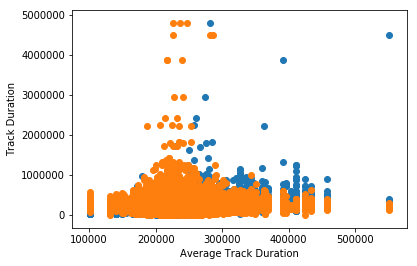

In [85]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

(array([14159., 24584., 21380., 18858., 17101., 12908., 11923.,  9961.,
         2828.,   423.]),
 array([ 1002971. ,  7822697.7, 14642424.4, 21462151.1, 28281877.8,
        35101604.5, 41921331.2, 48741057.9, 55560784.6, 62380511.3,
        69200238. ]),
 <a list of 10 Patch objects>)

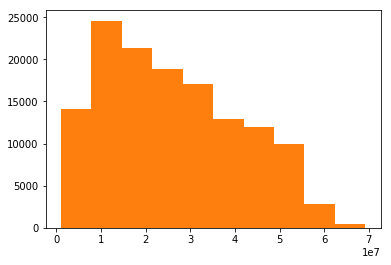

In [78]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)